In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import load_diabetes

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

from src.bootstrap import get_bs_theta_linreg, BootstrapLinreg, BootstrapLogreg
from src.amortized_bootstrap import AmortizedBootstrap
from src.utils import train_model, eval_bagging
from src.models import LinearRegressionModel, LogisticRegressionModel

# Diabetes

In [2]:
diabetes_data = load_diabetes(as_frame=True)

X = diabetes_data['data'][['bmi', 'bp']].values
y = diabetes_data['target'].values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
theta_bs = get_bs_theta_linreg(X_train, y_train, 1000)

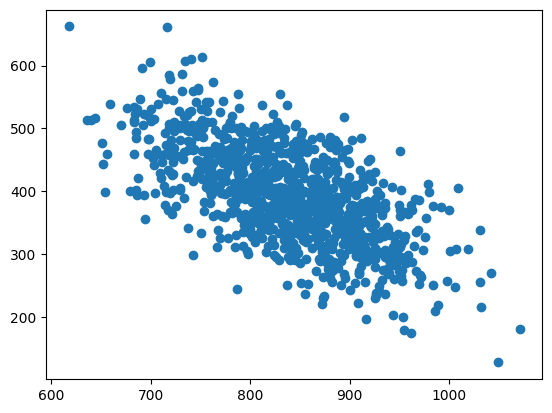

In [5]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [6]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [7]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [8]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(
    X=X_train_tensor,
    y=y_train_tensor, 
    amortized_bootstrap=amortized_bootstrap, 
    model_class=LinearRegressionModel, 
    optimizer=optimizer, 
    criterion=criterion, 
    T=1500, 
    k=5, 
    latent_size=25, 
    gradient_steps=5
)

100%|██████████| 1500/1500 [00:08<00:00, 183.69it/s]


In [9]:
torch.save(amortized_bootstrap.state_dict(), 'checkpoints/diabetes.pth')

In [10]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrap(amortized_bootstrap)

In [11]:
z = torch.randn((1000, 25))

theta_pred = amortized_bootstrap(z).detach().numpy()

Text(0.5, 0.98, 'Diabetes Dataset')

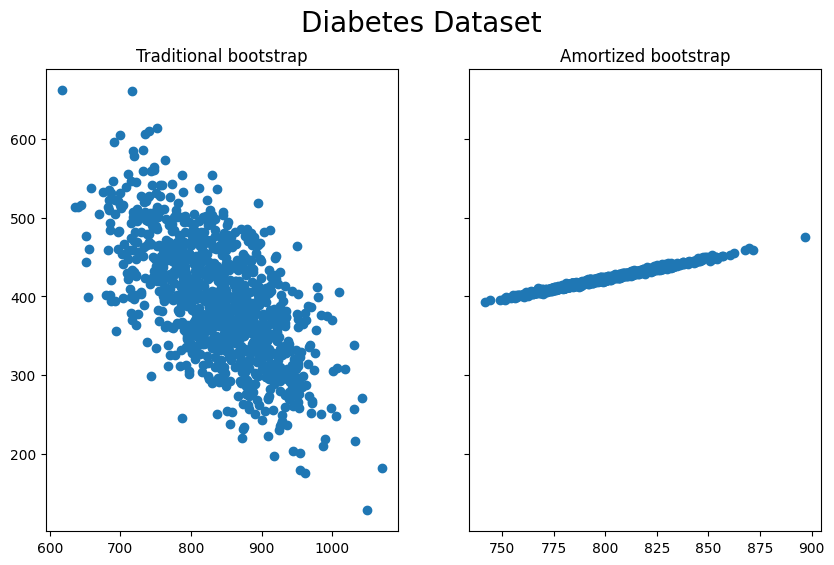

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

axes[0].scatter(theta_bs[:, 1], theta_bs[:, 2])
axes[1].scatter(theta_pred[:, 1], theta_pred[:, 2])

axes[0].set_title('Traditional bootstrap')
axes[1].set_title('Amortized bootstrap')

plt.suptitle('Diabetes Dataset', fontsize=20)

In [22]:
def agg_regression(preds):
    return np.stack(preds).mean(axis=0)

In [23]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, LinearRegressionModel, X_test, y_test, k_list, mean_squared_error, agg_regression)
mse_ambs = eval_bagging(am_bs_linreg, LinearRegressionModel, X_test, y_test, k_list, mean_squared_error, agg_regression)

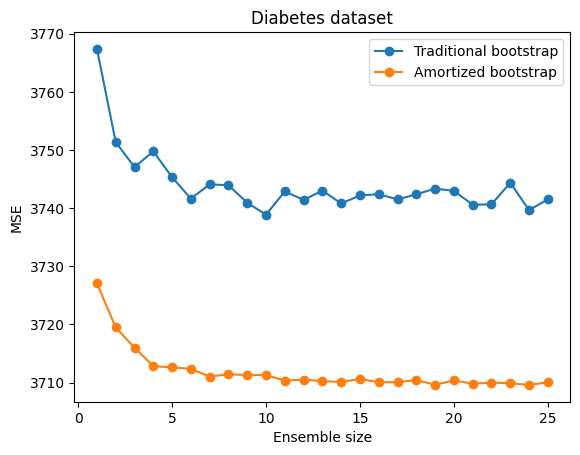

In [24]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.title('Diabetes dataset')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()

# Boston

In [25]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [26]:
X = data[:, [0, 5]]
y = target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
theta_bs = get_bs_theta_linreg(X_train, y_train, 1000)

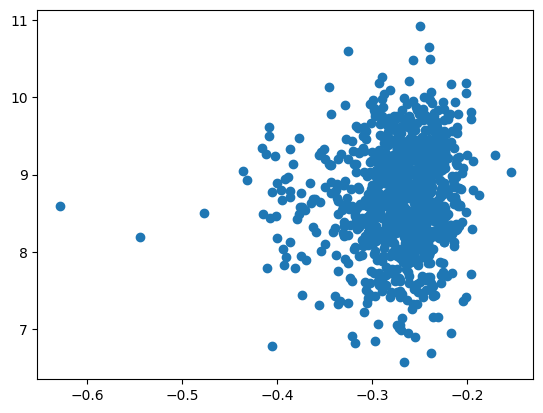

In [29]:
plt.scatter(theta_bs[:, 1], theta_bs[:, 2])

In [30]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.FloatTensor(y_train), torch.FloatTensor(y_test)

In [31]:
amortized_bootstrap = nn.Sequential(
    nn.Linear(25, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)

In [32]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-3)
criterion = nn.MSELoss()

history = train_model(
    X=X_train_tensor,
    y=y_train_tensor, 
    amortized_bootstrap=amortized_bootstrap, 
    model_class=LinearRegressionModel, 
    optimizer=optimizer, 
    criterion=criterion, 
    T=1100, 
    k=5, 
    latent_size=25, 
    gradient_steps=5
)

100%|██████████| 1100/1100 [00:06<00:00, 167.30it/s]


In [33]:
torch.save(amortized_bootstrap.state_dict(), 'checkpoints/boston.pth')

In [34]:
bs_linreg = BootstrapLinreg(X_train, y_train)
am_bs_linreg = AmortizedBootstrap(amortized_bootstrap)

In [35]:
theta_pred = am_bs_linreg.sample(1000)

Text(0.5, 0.98, 'Boston Dataset')

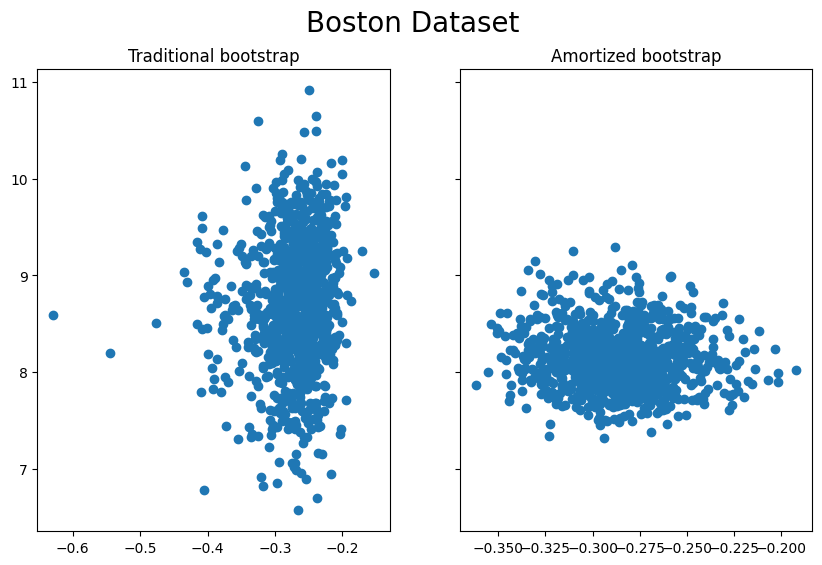

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

axes[0].scatter(theta_bs[:, 1], theta_bs[:, 2])
axes[1].scatter(theta_pred[:, 1], theta_pred[:, 2])

axes[0].set_title('Traditional bootstrap')
axes[1].set_title('Amortized bootstrap')

plt.suptitle('Boston Dataset', fontsize=20)

In [39]:
k_list = list(range(1, 26))

mse_bs = eval_bagging(bs_linreg, LinearRegressionModel, X_test, y_test, k_list, mean_squared_error, agg_regression)
mse_ambs = eval_bagging(am_bs_linreg, LinearRegressionModel, X_test, y_test, k_list, mean_squared_error, agg_regression)

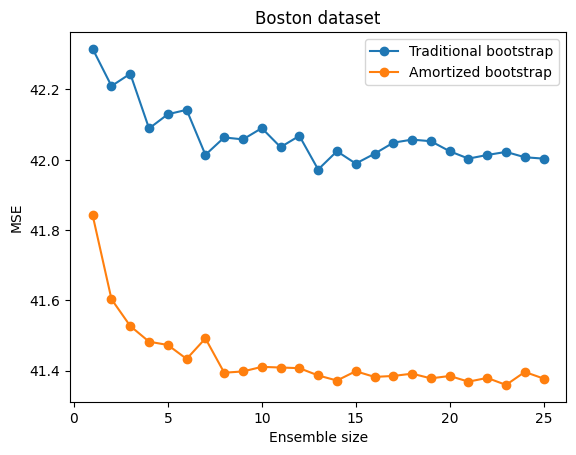

In [40]:
plt.plot(k_list, mse_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, mse_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.title('Boston dataset')
plt.xlabel('Ensemble size')
plt.ylabel('MSE')
plt.legend()

# Cover type

In [41]:
data = pd.read_csv('data/covertype_csv.csv')

In [42]:
X = data.drop('class', axis=1).values
y = data['class'].values - 1

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [44]:
X_train_tensor, X_test_tensor = torch.FloatTensor(X_train), torch.FloatTensor(X_test)
y_train_tensor, y_test_tensor = torch.LongTensor(y_train), torch.LongTensor(y_test)

In [45]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

amortized_bootstrap = nn.Sequential(
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 55*7),
    Reshape(-1, 55, 7)
)

In [46]:
optimizer = torch.optim.Adam(amortized_bootstrap.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

history = train_model(
    X=X_train_tensor[:500],
    y=y_train_tensor[:500], 
    amortized_bootstrap=amortized_bootstrap, 
    model_class=LinearRegressionModel, 
    optimizer=optimizer, 
    criterion=criterion, 
    T=800, 
    k=3, 
    latent_size=500, 
    gradient_steps=5
)

100%|██████████| 800/800 [00:40<00:00, 19.83it/s]


In [220]:
# torch.save(amortized_bootstrap.state_dict(), 'checkpoints/covertype_1500.pth')

In [47]:
# amortized_bootstrap.load_state_dict(torch.load('checkpoints/covertype_2500.pth'))

In [48]:
bs_logreg = BootstrapLogreg(X_train[:500], y_train[:500])
am_bs_logreg = AmortizedBootstrap(amortized_bootstrap)

In [49]:
def agg_classification(logits):
    probs = [np.exp(l) / np.sum(np.exp(l), axis=1, keepdims=True) for l in logits] 
    preds = np.stack(probs).sum(axis=0).argmax(axis=1)
    return preds

In [50]:
k_list = [1, 5, 10, 15, 20, 25]

accuracy_bs = eval_bagging(bs_logreg, LogisticRegressionModel, X_test, y_test, k_list, accuracy_score, agg_classification, 10)
accuracy_ambs = eval_bagging(am_bs_logreg, LogisticRegressionModel, X_test, y_test, k_list, accuracy_score, agg_classification, 10)

In [240]:
# np.save('accuracy_bs_2500.npy', accuracy_bs)
# np.save('accuracy_ambs_2500.npy', accuracy_ambs)

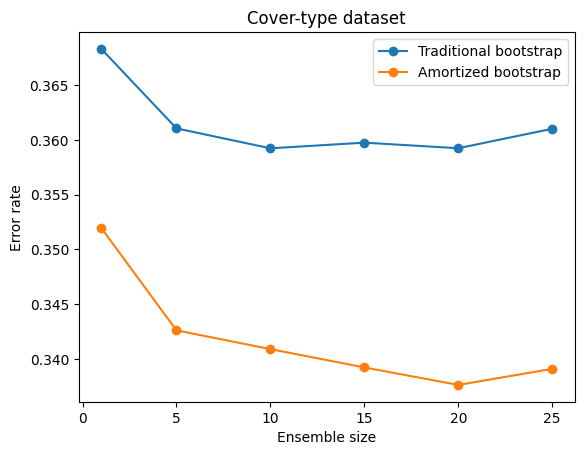

In [51]:
plt.plot(k_list, 1 - accuracy_bs.mean(axis=1), label='Traditional bootstrap', marker='o')
plt.plot(k_list, 1 - accuracy_ambs.mean(axis=1), label='Amortized bootstrap', marker='o')
plt.title('Cover-type dataset')
plt.xlabel('Ensemble size')
plt.ylabel('Error rate')
plt.legend()

In [242]:
accuracy_bs_500 = np.load('accuracy_bs_500.npy')
accuracy_ambs_500 = np.load('accuracy_ambs_500.npy')

accuracy_bs_1500 = np.load('accuracy_bs_1500.npy')
accuracy_ambs_1500 = np.load('accuracy_ambs_1500.npy')

accuracy_bs_2500 = np.load('accuracy_bs_2500.npy')
accuracy_ambs_2500 = np.load('accuracy_ambs_2500.npy')

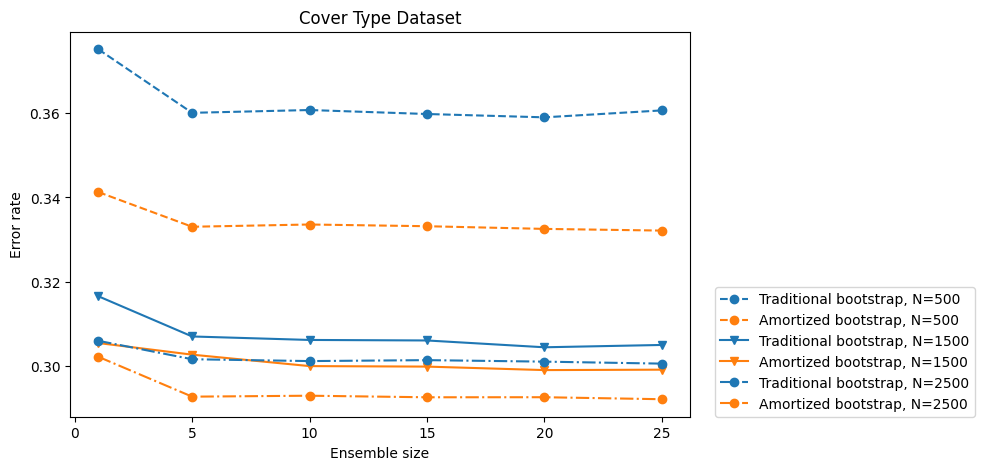

In [259]:
plt.figure(figsize=(8, 5))

plt.plot(k_list, 1 - accuracy_bs_500.mean(axis=1), label='Traditional bootstrap, N=500', marker='o', linestyle='--', color='tab:blue')
plt.plot(k_list, 1 - accuracy_ambs_500.mean(axis=1), label='Amortized bootstrap, N=500', marker='o', linestyle='--', color='tab:orange')

plt.plot(k_list, 1 - accuracy_bs_1500.mean(axis=1), label='Traditional bootstrap, N=1500', marker='v', color='tab:blue')
plt.plot(k_list, 1 - accuracy_ambs_1500.mean(axis=1), label='Amortized bootstrap, N=1500', marker='v', color='tab:orange')

plt.plot(k_list, 1 - accuracy_bs_2500.mean(axis=1), label='Traditional bootstrap, N=2500', marker='o', linestyle='-.', color='tab:blue')
plt.plot(k_list, 1 - accuracy_ambs_2500.mean(axis=1), label='Amortized bootstrap, N=2500', marker='o', linestyle='-.', color='tab:orange')

plt.title('Cover Type Dataset')
plt.xlabel('Ensemble size')
plt.ylabel('Error rate')
plt.legend(loc=(1.04, 0))